# Setup

In [1]:
# Import packages
import os
import re
import sys
import json
import string
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

tf.__version__ # 2.x

'2.3.0'

In [2]:
# Globals
BUFFER_SIZE = 5000
BUFFER_BATCH_SIZE = 64
VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 512
EMBEDDING_DIM = 128

# Setup input pipeline

In [3]:
dataset, info = tfds.load(name = "imdb_reviews", with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset["train"], dataset["test"]
print(train_dataset.element_spec, test_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)) (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [4]:
# View some examples from train
for review, label in train_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)


In [5]:
# View some examples from test
for review, label in test_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
Label: tf.Tens

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
for element in train_dataset:
    print(element[0][0])
    break

tf.Tensor(b'Well, I bought the Zombie Bloodbath trilogy thinking it would be mindless gory fun. That\'s what it is, without the fun. This film truly is mindless, it is absent of any plot or character development, or any sort of storyline. The basic problem with this movie is the kills and gore. Basically, every kill looks EXACTLY the same. ZOmbies ripping someone apart. Yeah, that\'s okay, but you need some original kills too. I mean it got really lame, every kill looked exactly the same, filmed exactly the same way. Thats what killed me. I love gore, and the gore in this film did nothing for me. It was just boring. No storyline, just the same lame scene over and over again with a different person. I wanted to like this movie, too. I love shot on video gore movies...like Redneck Zombies. But I couldn\'t kid myself. This film has it\'s good points, but none of those are in the film. I understand that many of the "zombies" helped out with the flood and there were like over 100 zombies, w

# Data processing

In [8]:
# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML).
# We will need to create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [9]:
encoder = TextVectorization(
    max_tokens = VOCAB_SIZE,
    standardize = custom_standardization,
    split = "whitespace",
    output_mode = "int",
    output_sequence_length = MAX_SEQUENCE_LENGTH
)

# Adapt to train text
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
for element in train_dataset:
    print(element[0][0])
    break

tf.Tensor(b'I have looked forward to seeing this since I first saw it listed in her work. Finally found it yesterday 2/13/02 on Lifetime Movie Channel.<br /><br />Jim Larson\'s comments about it being a "sweet funny story of 2 people crossing paths" were dead on. Writers probably shouldn\'t get a bonus, everyone else SRO for making the movie.<br /><br />Anybody who appreciates a romantic Movie SHOULD SEE IT.<br /><br />Natasha\'s screen presence is so warm and her smile so electric, to say nothing of her beauty, that anything she is in goes on my favorite list. Her TV and print interviews that I have seen are just as refreshing and well worth looking for.<br /><br />God Bless her, her family and future endeavors.<br /><br />This movie doesn\'t seem to available in DVD or video yet, but I would be the first to buy it and I think others would too.', shape=(), dtype=string)


In [11]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return encoder(text), label

# Vectorize the data.
train_dataset = train_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)

# Modelling

In [12]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.Dropout(0.3)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

# We create a model object
model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
]

In [14]:
# Train and validate model on sub-sample from test dataset
history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data = test_dataset,
    validation_steps = 10,
    callbacks = callbacks
)

Epoch 1/10
391/391 [==============================] - 7s 17ms/step - loss: 0.4867 - accuracy: 0.7271 - val_loss: 0.2779 - val_accuracy: 0.8859
Epoch 2/10
391/391 [==============================] - 6s 16ms/step - loss: 0.2505 - accuracy: 0.9034 - val_loss: 0.2517 - val_accuracy: 0.8922
Epoch 3/10
391/391 [==============================] - 6s 16ms/step - loss: 0.1616 - accuracy: 0.9389 - val_loss: 0.3255 - val_accuracy: 0.8953
Epoch 4/10
391/391 [==============================] - 6s 16ms/step - loss: 0.0919 - accuracy: 0.9678 - val_loss: 0.4103 - val_accuracy: 0.8719
Epoch 5/10
391/391 [==============================] - 7s 17ms/step - loss: 0.0542 - accuracy: 0.9806 - val_loss: 0.5602 - val_accuracy: 0.8594


In [15]:
# Evaluate model performance on test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print("Test loss;", test_loss)
print("Test accuracy:", test_acc)

391/391 [==============================] - 3s 8ms/step - loss: 0.5178 - accuracy: 0.8710
Test loss; 0.5177947282791138
Test accuracy: 0.8709999918937683


# Visualize model performance

In [16]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

(0.0, 0.5854941667988897)

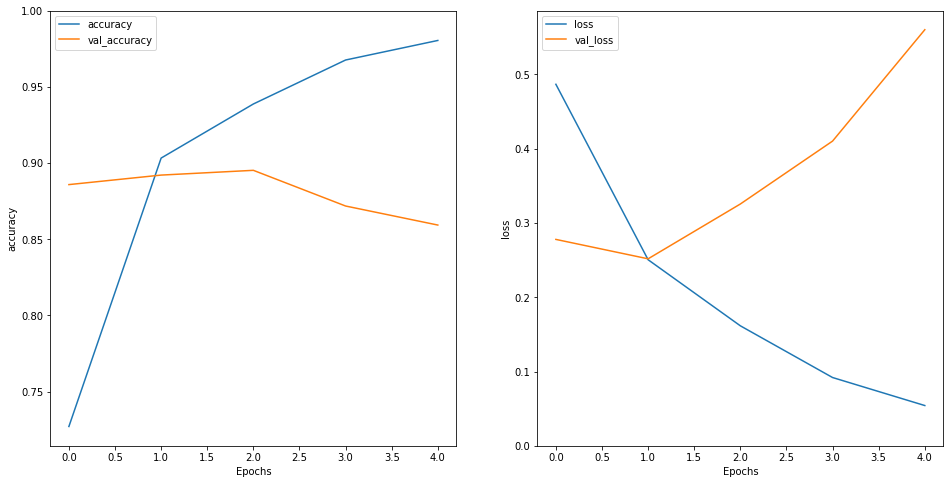

In [17]:
# Create a figure
plt.figure(figsize=(16,8))

# Plot accuracy graph
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None,1)

# Plot loss graph
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)